### PACE Rapid Response Notebook

To Do:
- adapt hackweek code to pull pace data for a given product, lat/lon extent, and time range defined before and after an event of interest
- spatially bin l2 data consistently?
- Make a mask of only pixels present both datasets (to prevent bias), compare data w/ pretty maps

In [3]:
import cartopy.crs as ccrs
import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib.colors import LogNorm
import cmocean

### Development test-case
Hurricane Erin, look at chl-a before and after hurricane for MAB
Timeline (using worldview): 
- Hurricane off florida/gulf stream PACE imagery on AUG 20
- AUG 21, hurricane passed and clear imagery
- Aug 18/19 hurricane not there yet

Lat/Lon bounds: 
UL:32.09, -76.63 
LR:27.78, -77.80


### Workflow
- use a datapoint in the center of AOI and time bounds/ earthaccess search to determine a granule form which we will define our L3M-like grid (see dask_gridding tutorial notebook)
- define crs, tramsform, shape from this L3M-like granule (chla_L3M_aoi in dask_griddding.ipynb notebook from hackweek)
- do another earthdata search, for full AOI over time period (1 week ish pre hurricane)
- open all and calculate average of parameter (in this case chl-a) using dask (follow dask_griddding.ipynb section 4)
- repeat above with timespan post hurricane, using same crs, tramsform, shape for gridding
- at this point, have pre and post hurricane chl averages on same spatial grid. now, mask each for pixels that have date pre and post hurricane
- make graphic showing before/after. Calculate average pre and post (using mask to avoid bias) and calculate a % increase in chl-a


In [4]:
min_lon = -76.6
min_lat = 27.8
max_lon = -77.8
max_lat = 32.1

In [5]:
# user bounds
tspan = ("2025-08-21", "2025-08-22")
bbox = (min_lon, min_lat, max_lon, max_lat)

# math
avg_lon = (min_lon + max_lon)/2; avg_lat = (min_lat + max_lat)/2
bbox_pt = (avg_lon, avg_lat, avg_lon, avg_lat)# single point at center of defined bounds

In [6]:
results = earthaccess.search_data(
    short_name="PACE_OCI_L2_BGC_NRT",
    temporal=tspan,
    bounding_box=bbox_pt,# logic to select central point of bounding box
)
len(results)

2

In [7]:
paths = earthaccess.open(results)
paths

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

[<File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250821T170142.L2.OC_BGC.V3_1.NRT.nc>,
 <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250821T184002.L2.OC_BGC.V3_1.NRT.nc>]

In [8]:
# this cell takes up to 2 min to run, opens dataset w/ datatree, put all variables together, and fully load dataset to memory to make map plotting faster
datatree = xr.open_datatree(paths[0])
dataset = xr.merge(datatree.to_dict().values())
dataset = dataset.set_coords(("longitude", "latitude"))
dataset = dataset.load()

C:\Users\gtrolley\AppData\Local\Temp\ipykernel_27124\119976617.py:2: FutureWarning: In a future version, xarray will not decode the variable 'day' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  datatree = xr.open_datatree(paths[0])
C:\Users\gtrolley\AppData\Local\Temp\ipykernel_27124\119976617.py:2: FutureWarning: In a future version, xarray will not decode the variable 'msec' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarr

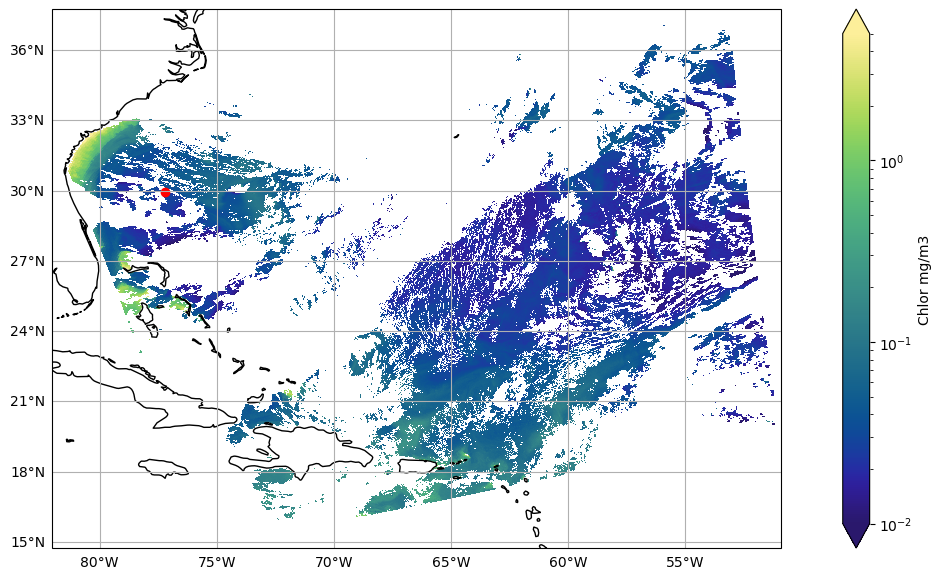

In [ ]:
fig = plt.figure(figsize=(16,7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = dataset['chlor_a'].plot(x="longitude", y="latitude", cbar_kwargs={'label': 'Chlor mg/m3'}, cmap=cmocean.cm.haline,norm=LogNorm(vmin=.01, vmax=5),  ax=ax)
ax.scatter([avg_lon],[avg_lat], c='r' )
                                       

In [10]:
# this cell takes up to 2 min to run, opens dataset w/ datatree, put all variables together, and fully load dataset to memory to make map plotting faster
datatree = xr.open_datatree(paths[1])
dataset2 = xr.merge(datatree.to_dict().values())
dataset2 = dataset2.set_coords(("longitude", "latitude"))
dataset2 = dataset2.load()

C:\Users\gtrolley\AppData\Local\Temp\ipykernel_27124\2535377678.py:2: FutureWarning: In a future version, xarray will not decode the variable 'day' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  datatree = xr.open_datatree(paths[1])
C:\Users\gtrolley\AppData\Local\Temp\ipykernel_27124\2535377678.py:2: FutureWarning: In a future version, xarray will not decode the variable 'msec' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xa

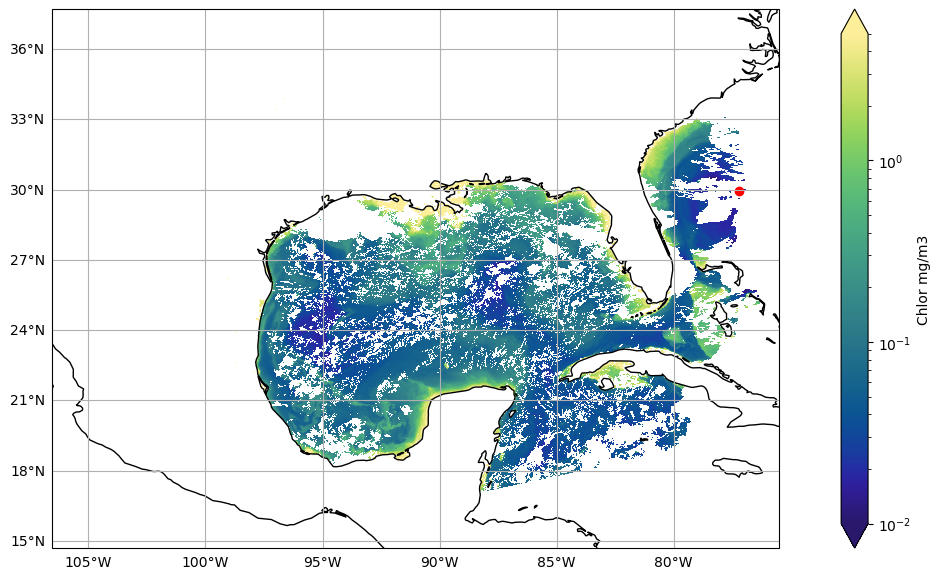

In [13]:
fig = plt.figure(figsize=(16,7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = dataset2['chlor_a'].plot(x="longitude", y="latitude", cbar_kwargs={'label': 'Chlor mg/m3'}, cmap=cmocean.cm.haline,norm=LogNorm(vmin=.01, vmax=5),  ax=ax)
ax.scatter([avg_lon],[avg_lat], c='r' )
                                       

In [16]:
dataset2

<xarray.Dataset> Size: 70MB
Dimensions:           (number_of_bands: 286, number_of_reflective_bands: 286,
                       number_of_lines: 1710, pixels_per_line: 1272)
Coordinates:
    longitude         (number_of_lines, pixels_per_line) float32 9MB -100.3 ....
    latitude          (number_of_lines, pixels_per_line) float32 9MB 14.7 ......
Dimensions without coordinates: number_of_bands, number_of_reflective_bands,
                                number_of_lines, pixels_per_line
Data variables: (12/29)
    wavelength        (number_of_bands) float64 2kB 315.0 316.0 ... 2.258e+03
    vcal_gain         (number_of_reflective_bands) float32 1kB 1.0 1.0 ... 1.0
    vcal_offset       (number_of_reflective_bands) float32 1kB 0.0 0.0 ... 0.0
    F0                (number_of_reflective_bands) float32 1kB 1.123e+03 ... ...
    aw                (number_of_reflective_bands) float32 1kB 0.0947 ... 2.1...
    bbw               (number_of_reflective_bands) float32 1kB 0.009639 ... 2...
    ...                ...
    carbon_phyto      (number_of_lines, pixels_per_line) float32 9MB nan ... nan
    poc               (number_of_lines, pixels_per_line) float32 9MB nan ... nan
    chlor_a_unc       (number_of_lines, pixels_per_line) float32 9MB nan ... nan
    carbon_phyto_unc  (number_of_lines, pixels_per_line) float32 9MB nan ... nan
    l2_flags          (number_of_lines, pixels_per_line) int32 9MB 1073742384...
    tilt              (number_of_lines) float32 7kB 19.86 19.86 ... 19.86 19.86
Attributes: (12/47)
    title:                             OCI Level-2 Data BGC
    product_name:                      PACE_OCI.20250821T184002.L2.OC_BGC.V3_...
    processing_version:                3.1
    history:                           l2gen par=/data10/sdpsoper/vdc/vpu9/wo...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_min:                -106.51808
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     0.9772875308990479
    geospatial_bounds:                 POLYGON ((19.84309 -75.53156, 14.70270...